In [15]:
import math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.stats import chi2, poisson, t


def cmp_float(lhs, rhs):
    return math.fabs(lhs - rhs) < 0.001


def check_distr_func(distr_func, var, low, high) -> bool:
    low_val = float(distr_func.subs(var, low).evalf())
    if not cmp_float(low_val, 0):
        return False
    high_val = float(distr_func.subs(var, high).evalf())
    if not cmp_float(high_val, 1):
        return False
    return True


def calc_statistical_mean(values: list) -> float:
    return sum(values) / len(values)


def calc_dispersion(values: list) -> float:
    sum = 0
    m = calc_statistical_mean(values)
    for i in values:
        sum += (i - m) ** 2
    return sum / (len(values) - 1)


def create_histogram(values: list, intervals_num: int) -> None:
    plt.hist(values, bins=intervals_num)
    plt.show()


def calc_distr_density(distr_func, var):
    distr_density = distr_func.diff(var)
    return distr_density


def calc_math_expectation(distr_density, var, low, high):
    math_expectation = sp.integrate(distr_density * var, (var, low, high))
    return float(math_expectation)


def calc_theoretical_dispersion(distr_density, var, low, high):
    math_expectation = calc_math_expectation(distr_density, var, low, high)
    dispersion = float(sp.integrate((var ** 2) * distr_density, (var, low, high))) - math_expectation ** 2
    return dispersion


def calc_mean_confidence_interval(data: list, confidence_level: float) -> tuple:
    mean = calc_statistical_mean(data)
    dispersion = calc_dispersion((data))
    n = len(data)
    tmp = t.ppf(confidence_level, n - 1)
    eps = np.sqrt(dispersion) * tmp / np.sqrt(n - 1)
    return (mean - eps, mean + eps)


def calc_standard_deviation_conf_interval(data: list, confidence_level: float) -> tuple:
    mean = calc_statistical_mean(data)
    dispersion = calc_dispersion(data)
    standard_deviation = np.sqrt(dispersion)

    n = len(data)

    a1 = (1 - confidence_level) / 2.0
    a2 = (1 + confidence_level) / 2.0

    standard_deviation_left = np.sqrt((n - 1) / chi2.ppf(a2, n - 1)) * standard_deviation
    standard_deviation_right = np.sqrt((n - 1) / chi2.ppf(a1, n - 1)) * standard_deviation
    return (standard_deviation_left, standard_deviation_right)


def build_statistical_series(values: list, intervals_num: int, ):
    intervals = np.linspace(0, np.max(values), intervals_num)
    statistical_series = {(intervals[i], intervals[i + 1]): 0 for i in range(len(intervals) - 1)}
    for element in values:
        for i in range(len(intervals) - 1):
            if element >= intervals[i] and element < intervals[i + 1]:
                statistical_series[(intervals[i], intervals[i + 1])] += 1
                break
    return statistical_series


def test_hypothesis(statistical_series, distr_func, var, significance_level):
    # Хи квадрат
    n = sum(statistical_series.values())
    curr_chi2 = 0
    for key, value in statistical_series.items():
        pi = float(distr_func.subs(var, key[1]).evalf()) - float(distr_func.subs(var, key[0]).evalf())
        npi = pi * n
        curr_chi2 += ((value - npi) ** 2) / npi
    crit_chi2 = chi2.ppf(1 - significance_level, len(statistical_series) - 1)
    print(f"Chi2: {curr_chi2}")
    print(f"Crit Chi2: {crit_chi2}")
    return curr_chi2 < crit_chi2


def calc_math_expectation_uniform(a: int, b: int):
    return (a + b) / 2


def calc_dispersion_uniform(a: int, b: int):
    n = b - a + 1
    return (n**2 - 1) / 12


def test_hypothesis_uniform(statistical_series, significance_level, a: int, b: int):
    n = sum(statistical_series.values())
    curr_chi2 = 0
    pi = 1 / (b - a + 1)
    npi = pi * n
    for key, value in statistical_series.items():
        curr_chi2 += ((value - npi) ** 2) / value
    crit_chi2 = chi2.ppf(1 - significance_level, len(statistical_series) - 1)
    print(f"Chi2: {curr_chi2}")
    print(f"Crit Chi2: {crit_chi2}")
    return curr_chi2 < crit_chi2


In [4]:
import matplotlib.pyplot as plt
import sympy as sp
import random


# RV - random value
class RVGenerator:
    def __init__(self, distr_func, x, y, low, high):
        self._distr_func = distr_func
        self._x = x
        self._y = y
        self._inverse_func = None
        self._low = low
        self._high = high

        self._calc_inverse_func()


    def generate(self) -> float:
        uniform_rv = random.uniform(0, 1)
        rv = sp.simplify(self._inverse_func.subs(self._y, uniform_rv).evalf())
        return float(rv)

    def get_inverse_func(self):
        return self._inverse_func

    def _calc_inverse_func(self):
        solutions = sp.solve(self._distr_func - self._y, self._x)
        self._inverse_func = self._find_suitable_solution(solutions)
        if self._inverse_func is None:
            raise RuntimeError("Failed to find the inverse function")

    def _find_suitable_solution(self, solutions: list):
        points_to_check = [0, 0.25, 0.5, 0.75, 1]
        for s in solutions:
            for point in points_to_check:
                val = sp.simplify(s.subs(self._y, point).evalf())
                if isinstance(val, sp.core.numbers.Float):
                    val = float(val)
                    if val >= self._low and val <= self._high:
                        return s
        return None


def read_distribution_func() -> str:
    distr_func_str = input("Введите многочлен в формате Python (например, 'x**2 + 2*x - 3'): ")
    return str_to_distribution_func(distr_func_str)


def str_to_distribution_func(distribution_func_str: str):
    try:
        distr_func = sp.sympify(distribution_func_str)
    except sp.SympifyError:
        print("Ошибка: Некорректный ввод многочлена.")
        exit()
    return distr_func

Введите нижнюю границу СВ:  0
Введите верхнюю границу СВ:  1
Введите многочлен в формате Python (например, 'x**2 + 2*x - 3'):  x**2


distr_func x**2


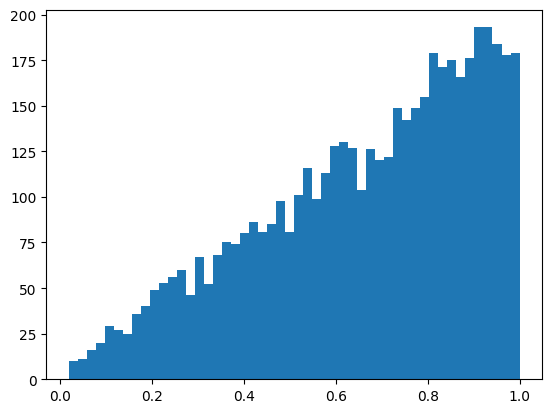

distr_density:  2*x
Statistical mean:  0.662058597736377
Math expectation:  0.6666666666666666
Practical dispersion:  0.05775230175195986
Theoretical dispersion 0.05555555555555558
Доверительный интервал для мат. ожидания:  (0.6541489522343918, 0.6699682432383621)
Доверительный интервал для среднеквадратичного отклонения:  (0.23427203072989097, 0.24666012220210948)
Chi2: 89.49311836155418
Crit Chi2: 90.20377662708395
Нет оснований отвергать гипотезу о том, что генеральная совокупность распределена по данному закону распределения.


In [16]:
def task1() -> None:
    random.seed(1001)
    x, y = sp.symbols("x y")
    # low = float(input("enter the lowest possible value for the random value: "))
    # high = float(input("enter the highest possible value for the random value: "))
    # if low > high:
    #     print("Incorrect input: low > high")
    #

    # low = 0
    # high = 2
    # distr_func_str = '(1 / 8) * x**2 + x / 4'


    # low = 0
    # high = 1
    # distr_func_str = 'x**2'

    low = float(input("Введите нижнюю границу СВ: "))
    high = float(input("Введите верхнюю границу СВ: ")) 
    distr_func_str = input("Введите многочлен в формате Python (например, 'x**2 + 2*x - 3'): ")
    distr_func = str_to_distribution_func(distr_func_str)
    print("distr_func", distr_func)
    is_correct_distr_func = check_distr_func(distr_func, x, low, high)
    if not is_correct_distr_func:
        print("Incorrect distr func")
        return

    try:
        generator = RVGenerator(distr_func, x, y, low, high)
    except RuntimeError as ex:
        print(ex)
        return

    values = [generator.generate() for _ in range(5000)]

    create_histogram(values, 50)

    statistical_mean = calc_statistical_mean(values)
    practical_dispersion = calc_dispersion(values)
    distr_density = calc_distr_density(distr_func, x)
    print("distr_density: ", distr_density)
    math_expectation = calc_math_expectation(distr_density, x, low, high)
    theoretical_dispersion = calc_theoretical_dispersion(distr_density, x, low, high)

    print("Statistical mean: ", statistical_mean)
    print("Math expectation: ", math_expectation)
    print("Practical dispersion: ", practical_dispersion)
    print("Theoretical dispersion", theoretical_dispersion)

    print(f"Доверительный интервал для мат. ожидания: ", calc_mean_confidence_interval(values, 0.99))
    print(f"Доверительный интервал для среднеквадратичного отклонения: ", calc_standard_deviation_conf_interval(values, 0.99))

    statistical_series = build_statistical_series(values, 100)
    is_true = test_hypothesis(statistical_series, distr_func, x, 0.7)

    if is_true:
        print("Нет оснований отвергать гипотезу о том, что генеральная совокупность распределена по "
              "данному закону распределения.")
    else:
        print("Нет оснований принять гипотезу о том, что генеральная совокупность распределена "
              "по данному закону распределения")

task1()

Введите а:  20
Введите b: 55


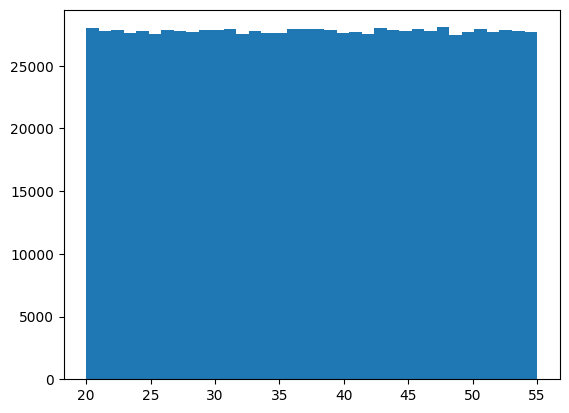

Statistical mean:  37.499471
Math expectation:  37.5
Practical dispersion:  107.93641965655053
Theoretical dispersion 107.91666666666667
Доверительный интервал для мат. ожидания:  (37.4753019502603, 37.5236400497397)
Доверительный интервал для среднеквадратичного отклонения:  (10.3703546797355, 10.408200458340144)
Chi2: 30.821717856897376
Crit Chi2: 31.24580239061489
Нет оснований отвергать гипотезу о том, что генеральная совокупность распределена по данному закону распределения.


In [25]:
import matplotlib.pyplot as plt
import sympy as sp
import random

class DiscreteUniformDistributionGenerator:
    def __init__(self, a: int, b: int):
        self._a = a
        self._b = b
        self._section_len = 1 / (self._b - self._a + 1)

    def generate(self) -> int:
        rv = random.uniform(0, 1)
        return self._a + int(rv / self._section_len)


def task2() -> None:
    random.seed(1087)
    try:
        # a = 0
        # b = 10
        a = int(input("Введите а: "))
        b = int(input("Введите b:"))
    except Exception as ex:
        print("Incorrect input")
        return

    generator = DiscreteUniformDistributionGenerator(a, b)
    values = [generator.generate() for _ in range(1000000)]
    intervals_num = b - a + 1

    create_histogram(values, intervals_num)

    statistical_mean = calc_statistical_mean(values)
    practical_dispersion = calc_dispersion(values)

    n = b - a + 1
    math_expectation = calc_math_expectation_uniform(a, b)
    theoretical_dispersion = calc_dispersion_uniform(a, b)

    print("Statistical mean: ", statistical_mean)
    print("Math expectation: ", math_expectation)
    print("Practical dispersion: ", practical_dispersion)
    print("Theoretical dispersion", theoretical_dispersion)

    print(f"Доверительный интервал для мат. ожидания: ", calc_mean_confidence_interval(values, 0.99))
    print(f"Доверительный интервал для среднеквадратичного отклонения: ",
          calc_standard_deviation_conf_interval(values, 0.99))

    statistical_series = {v: 0 for v in values}
    for v in values:
        statistical_series[v] += 1

    is_true = test_hypothesis_uniform(statistical_series, 0.65, a, b)

    if is_true:
        print("Нет оснований отвергать гипотезу о том, что генеральная совокупность распределена по "
              "данному закону распределения.")
    else:
        print("Нет оснований принять гипотезу о том, что генеральная совокупность распределена "
              "по данному закону распределения")

task2()